In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [114]:
# store = pd.HDFStore('cse6250_features.h5')
# df = store['df']
# store.close()
# dfNotes = pd.read_csv('topicfeatures.csv',header=None)
# dfNotes.columns = ['subject_id'] + ['topic_'+str(x) for x in range(1,21)]
# # dfNotes.columns
# df = df.merge(dfNotes)


In [115]:
# trainDF.to_csv('./data/train.csv',index=False)
# testDF.to_csv('./data/test.csv',index=False)

In [116]:
# standardCols = ['first_admit_age', 'angus']#'subject_id',

In [152]:
import os
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

from utils import xtrain, evaluate
from mymodels import loadDataSet,MyCNN, MyRNN
from stats import Model,statScores,func,splitNRunModel
from plots import plot_learning_curves, plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance

In [121]:
import torch.nn.functional as F
class MyCNN(nn.Module):
	def __init__(self,size):
		super(MyCNN, self).__init__()
		self.size = size
		self.conv1 = nn.Conv1d(in_channels=1,out_channels=6,kernel_size=5)
		self.pool = nn.MaxPool1d(kernel_size=2)
		self.conv2 = nn.Conv1d(in_channels=6,out_channels=16,kernel_size=5)
		self.linear1 = nn.Linear(self.size,128)
		self.linear2 = nn.Linear(128,64)
		self.linear_out = nn.Linear(128,2)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		# print(x.shape)
		x = x.view(-1, self.size)
		x = F.relu(self.linear1(x))
		x = self.linear_out(x)
		return x

In [122]:
PATH_OUTPUT = "./mimic/sepsis/"
os.makedirs(PATH_OUTPUT, exist_ok=True)

PATH_TRAIN_FILE = './data/train.csv'
PATH_TEST_FILE = './data/test.csv'

# cols = list(df.columns)[8:] + standardCols
# useDF = df[cols]
trainDF, testDF = pd.read_csv(PATH_TRAIN_FILE),pd.read_csv(PATH_TEST_FILE)
withOutNotes = list(trainDF.columns[0:78]) + ['first_admit_age', 'angus']

results = []
models = []

def runCNNRNN(cols,label):
    BATCH_SIZE = 42
    size   = 16*21
        
    if(label == '_with_Out_Notes'):
        BATCH_SIZE = 32
        size = 16*16
    for modelType in ['CNN','RNN']:
        if modelType=='RNN':
            model = MyRNN()
            save_file = 'myRNN'+label+'.pth'

        elif modelType == 'CNN':
            model = MyCNN(size)
            save_file = 'myCNN'+label+'.pth'
#             BATCH_SIZE = 42

        models.append(modelType+label)
        NUM_EPOCHS = 10	
        USE_CUDA = False  # Set 'True' if you want to use GPU
        NUM_WORKERS = 0 

        

        train_dataset = loadDataSet(trainDF[cols],modelType)
        test_dataset = loadDataSet(testDF[cols],modelType)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


        lrate = 0.1

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        criterion.to(device)

        for epoch in range(NUM_EPOCHS):
            train_loss, train_accuracy = xtrain(model, device, train_loader, criterion, optimizer, epoch)
            torch.save(model, os.path.join(PATH_OUTPUT, save_file))

        best_model = torch.load(os.path.join(PATH_OUTPUT, save_file))
        test_loss, test_accuracy, test_results = evaluate(best_model, device, test_loader, criterion)
        results.append(test_results)


runCNNRNN(trainDF.columns,'_with_Notes')
runCNNRNN(withOutNotes,'_with_Out_Notes')
# y_test,y_pred,y_prob = zip(*test_results)
# statScores(y_test,y_pred,y_prob,modelType)

# plot_confusion_matrix(test_results, ['No Sepsis','Sepsis'])

//anaconda/envs/hw5/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type MyCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [169]:
results = results[:4]
models = models[:4]

In [170]:
def runNewModel(train,test,mlModels):
    X_train,y_train = train.loc[:, train.columns != 'angus'],train.angus
    X_test,y_test = test.loc[:, test.columns != 'angus'],test.angus
    output = []
    for mlModel in mlModels:
            model = mlModel.model
            model.fit(X_train, y_train)
            if('xgboost'==mlModel.label):
                plot_importance(model,max_num_features=15)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:,1]
            output.append(zip(y_test,y_pred,y_prob))
#     print(output)
    return output
# runNewModel(trainDF,testDF,[Model(LogisticRegression(),'Logistic')])
results.extend(runNewModel(trainDF,testDF,[Model(LogisticRegression(),'Logistic')]))
models.append('Logistic with Notes')


results.extend(runNewModel(trainDF[withOutNotes],testDF[withOutNotes],[Model(LogisticRegression(),'Logistic with out notes')]))
models.append('Logistic with out Notes')



//anaconda/envs/hw5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda/envs/hw5/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda/envs/hw5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda/envs/hw5/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


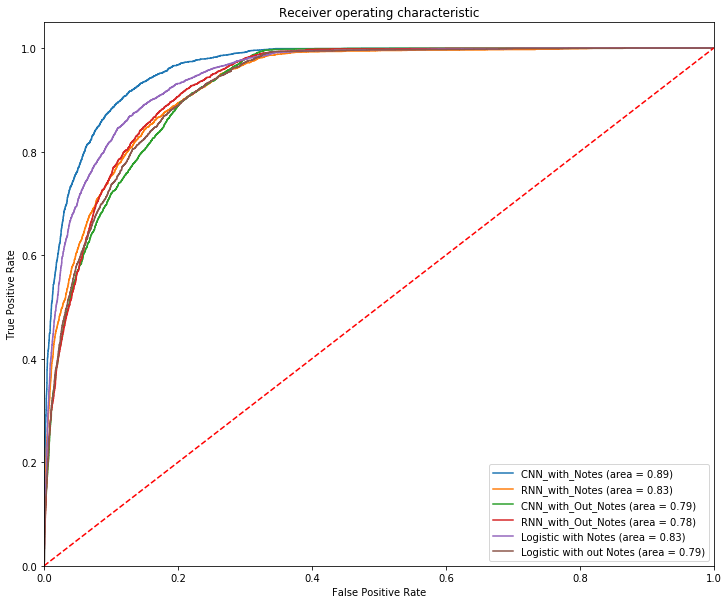

In [128]:
def rocCurves(testResultsL,modelLabelsL,saveFig):
    plt.figure(figsize=(12, 10))
    for i,test_results in enumerate(testResultsL):
#         print(test_results)
        y_test,y_pred,y_prob = zip(*test_results)
        model = modelLabelsL[i]
        logit_roc_auc = roc_auc_score(y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label= model + ' (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig(saveFig)
    plt.show()
    
rocCurves(results,models,'Notes.jpg')

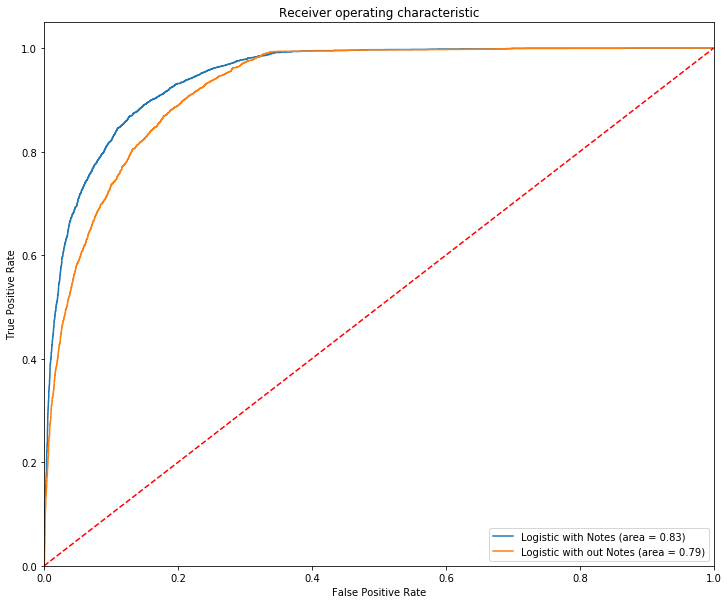

In [133]:
rocCurves(results[4:],models[4:],'LogisticWIthNWIthOut.jpg')

In [138]:
accuracy = []
for i,test_results in enumerate(results):
    modeleName = models[i]
    y_test,y_pred,y_prob = zip(*test_results)
    accuracy.append(accuracy_score(y_test,y_pred))
    
accDF = pd.DataFrame({'model':models,'accuracy':accuracy})
accDF

,model,accuracy
0,CNN_with_Notes,0.896020
1,RNN_with_Notes,0.858546
2,CNN_with_Out_Notes,0.848796
3,RNN_with_Out_Notes,0.853162
4,Logistic with Notes,0.882777
5,Logistic with out Notes,0.852216


In [139]:
accDF.to_csv('accuracy.csv',index=False)

In [167]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix1(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(title+'.jpg')

def plot_confusion_matrix(results, class_names,label):
	# TODO: Make a confusion matrix plot.
	# TODO: You do not have to return the plots.
	# TODO: You can save plots as files by codes here or an interactive way according to your preference.
	# print(results)
	y_true,y_pred,_ = zip(*results)
	cnf_matrix = confusion_matrix(y_true, y_pred)
	plot_confusion_matrix1(cnf_matrix,class_names,title=label)

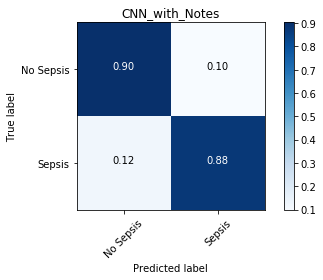

In [159]:
plot_confusion_matrix(results[0], ['No Sepsis','Sepsis'],models[0])

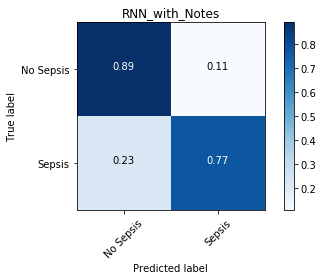

In [160]:
plot_confusion_matrix(results[1], ['No Sepsis','Sepsis'],models[1])

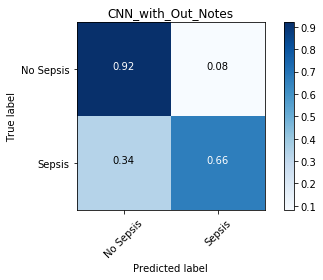

In [161]:
plot_confusion_matrix(results[2], ['No Sepsis','Sepsis'],models[2])

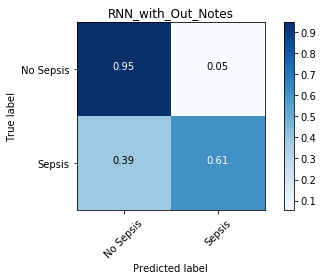

In [162]:
plot_confusion_matrix(results[3], ['No Sepsis','Sepsis'],models[3])

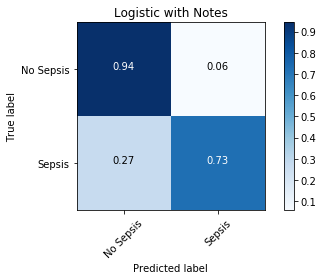

In [171]:
plot_confusion_matrix(results[4], ['No Sepsis','Sepsis'],models[4])

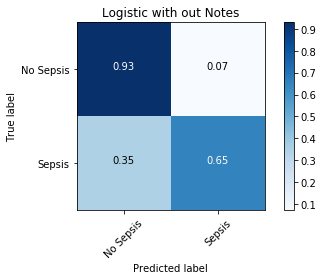

In [172]:
plot_confusion_matrix(results[5], ['No Sepsis','Sepsis'],models[5])